In [1]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time
import math
import os
import gzip

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

# keras
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.layers import Input, LSTM, Flatten, Dense, Dropout, TimeDistributed, Conv1D
from keras.utils import np_utils

from tensorflow import set_random_seed

# functions to calculate WAMP, VWAP, etc. and display plots
from functions.market.features import *
from functions.market.plots import *
from functions.preprocessing import *
from functions.evaluation import *

Using TensorFlow backend.


In [2]:
np.random.seed(1234)
set_random_seed(1234)

In [3]:
n_labels = 3

if n_labels == 2:
    class_names = [-1, 1]
elif n_labels == 3:
    class_names = [-1, 0, 1]
else:
    class_names = []

Dataset size: 37440
Depth: 20
Label distribution in the whole dataset:
UP labels: 12667 	 33.83279914529915%
NO_MOVE labels: 12801 	 34.19070512820513%
DOWN labels: 11972 	 31.976495726495724%


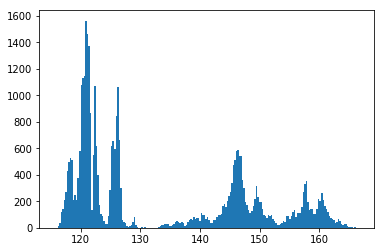

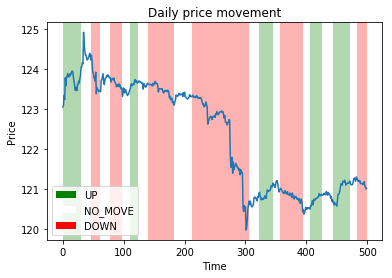

In [4]:
with gzip.GzipFile("data/kraken/eth_eur_d20_lw30_sw4320_l3.npy.gz", "r") as file:
    data = np.load(file)
    
lob_depth = int(len(data["snapshot"][0])/2)

print("Dataset size:", len(data))
print("Depth:", lob_depth)

print("Label distribution in the whole dataset:")
count_labels(data["label"])

plt.hist(data["vwap"], bins=200)
plot_labels(data["vwap"][:500], data["label"][:500])
plt.show()

# DATA PREPARATION

## Timestep sampling

In [5]:
timestep = 100

input_shape = (timestep, 2*lob_depth*2)

dataset = np.zeros([len(data)-timestep], dtype=[('input', np.float32, input_shape), ('label', int, 1)])

for i in range(0, len(dataset)):
    dataset["label"][i] = data["label"][i+timestep-1]    
    dataset["input"][i] = data["snapshot"][i:i+timestep,:,0:2].reshape(-1, 2*lob_depth*2)

In [6]:
len(dataset)

37340

In [7]:
dataset["input"][0].shape

(100, 80)

In [8]:
dataset["input"][0]

array([[0.48748952, 2.09832   , 0.49165833, ..., 0.8274785 , 0.8542668 ,
        0.91465044],
       [0.5291679 , 2.009497  , 0.5458399 , ..., 1.2686731 , 0.8751044 ,
        1.2773902 ],
       [0.59585583, 1.1506423 , 0.60002464, ..., 0.5886412 , 1.029318  ,
        0.5894974 ],
       ...,
       [0.675047  , 1.604599  , 0.6833814 , ..., 1.1863217 , 1.091837  ,
        1.2649857 ],
       [0.60835904, 0.85078657, 0.62086225, ..., 0.86171263, 1.0043083 ,
        0.9488846 ],
       [0.641703  , 0.37862498, 0.6458718 , ..., 0.4028152 , 1.012646  ,
        0.6301596 ]], dtype=float32)

In [9]:
dataset["label"].shape

(37340,)

## Train-validation-test split and shuffle

In [10]:
tmp, test = train_test_split(dataset, test_size=0.1, random_state=42, shuffle = False, stratify = None)
train, validation = train_test_split(tmp, test_size=0.2, random_state=42, shuffle = False, stratify = None)

In [11]:
# shuffle (only after splitting!!!)
np.random.shuffle(train)
np.random.shuffle(validation)
np.random.shuffle(test)

In [12]:
# input
X_train = train['input']
X_validation = validation['input']
X_test = test['input']

# output
Y_train = train['label']
Y_validation = validation['label']
Y_test = test['label']

print("Train shape:", X_train.shape)
print("Label distribution in train set:")
count_labels(Y_train)

print()

print("Validation shape:", X_validation.shape)
print("Label distribution in train set:")
count_labels(Y_validation)

print()

print("Test shape:", X_test.shape)
print("Label distribution in test set:")
count_labels(Y_test)

# one hot encoding
Y_train = np_utils.to_categorical(Y_train, n_labels)
Y_validation = np_utils.to_categorical(Y_validation, n_labels)
Y_test = np_utils.to_categorical(Y_test, n_labels)

Train shape: (26884, 100, 80)
Label distribution in train set:
UP labels: 9280 	 34.51867281654516%
NO_MOVE labels: 9060 	 33.70034221098051%
DOWN labels: 8544 	 31.780984972474336%

Validation shape: (6722, 100, 80)
Label distribution in train set:
UP labels: 2299 	 34.20113061588813%
NO_MOVE labels: 2366 	 35.197857780422495%
DOWN labels: 2057 	 30.601011603689376%

Test shape: (3734, 100, 80)
Label distribution in test set:
UP labels: 1057 	 28.307445099089453%
NO_MOVE labels: 1341 	 35.91322978039636%
DOWN labels: 1336 	 35.779325120514194%


# Neural network

In [13]:
def plot_history(network_history):
    
    #set pltting attributes
    #loss-epochs
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    #accuracy-epochs
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])
    
    plt.show()

In [14]:
inputs = Input(shape=X_train[0].shape)

conv = Conv1D(filters=32,
               kernel_size=2,
               strides=2,
               activation='relu',
               padding='same')(inputs)

# inception

lstm = LSTM(
        64, 
        dropout=0.4, 
        recurrent_dropout=0.4,
        return_sequences=True)(conv)

x = TimeDistributed(Dense(10, activation="relu"))(lstm)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = Dropout(0.2)(x)

predictions = Dense(3, activation="softmax")(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 80)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            5152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 64)            24832     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 10)            650       
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
__________

In [ ]:
csv_logger = CSVLogger('history_log.csv', append=True, separator=';')

#setup early stopping
es = EarlyStopping(monitor='val_acc', patience=10, verbose=1, min_delta=0.005)

#we are going to keep only the best model
mcp = ModelCheckpoint(filepath='weights.hdf5', verbose=1 , save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mae','acc'])

In [ ]:
# set parameters and start learning
history = model.fit(X_train, Y_train, 
          batch_size=1024, 
          epochs=100, # early stopping detects the end
          verbose=1, 
          validation_data=(X_validation, Y_validation), 
          shuffle=True,
          callbacks=[mcp, es]
         )

In [ ]:
plot_history(history)

In [ ]:
# load back best model (early stopping + model checkpoint)
model = load_model('weights.hdf5')

In [ ]:
Y_pred = np.argmax(model.predict(X_test), axis=1)
Y_true = np.argmax(Y_test, axis=1)

In [ ]:
Y_pred = np.argmax(model.predict(X_train), axis=1)
Y_true = np.argmax(Y_train, axis=1)

In [ ]:
metrics = evaluate_result(Y_true, Y_pred)
for key in metrics:
    print(key + ":", metrics[key], '%')
print()

title = 'Simple LSTM model on of 30 days ETH_EUR data'

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, classes=class_names, title=title)

# Plot normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, classes=class_names, normalize=True, title=title)